# VEDA PEC (Polygon Evaluation and Comparison) DEMO: Kincade Fire 2019

### Summary

This notebook demonstrates an OOP [write out OOP] implementation of a benchmarking system to compare a VEDA input [FEDS fire perimeter] against [other fire perimeter data sources], and then store in an output object. [FEDS] inputs and reference inputs can use either pre-defined settings [write out, does pre-defined settigns mean the API?], or can accept (valid) user-written paths [to what?]. Outputs can be printed, plotted, and/or serialized/realoaded.

Motivation: simple way to systematically say "this vs that" [of what?] and archive results; save time for researchers by implementing popular calculation and archiving methods. 

Disclaimer: the serializing portion is incomplete, this notebook does not demonstrate persistence of output. Plotting is also demoed but not yet implemented in the classes as intended.

### User Inputs for Comparison: time, bbox, VEDA set, reference set

Note for inputs:
- VEDA Input: you must specify a valid title (e.g. firenrt) and collection (e.g. public.eis_fire_lf_perimeter_archive). [Collections are listed here [link to documentation https://nasa-impact.github.io/veda-docs/notebooks/tutorials/mapping-fires.html]. Analyses only work for *perimeter* based features.] 
- Reference Input: as above you must specify a valid title and access method such that the proper methods are applied. [What are example reference inputs?]


[We need detailed explanations for each input option, and what they mean. For each input: - Where is it coming from, who generated it, what time period does it cover, what spatial range, and what level is the code able to handle it?]

In [1]:
import Utilities
import Input_VEDA
import Input_Reference
import Output_Calculation

from Input_VEDA import InputVEDA
from Input_Reference import InputReference
from Output_Calculation import OutputCalculation
from Utilities import *

In [8]:
# this is the ONLY thing users are intended to modify!
# inputs for searching VEDA and nifc sets

# START TIME
year_start = 2019
month_start = 10
day_start = 23
hour_start = 0
minute_start = 0
second_start = 0
tz_offset_hours_start = 0
tz_offset_minutes_start = 0
utc_offset_start = '00:00'

# END TIME
year_stop = 2019
month_stop = 11
day_stop = 14
hour_stop = 0
minute_stop = 0
second_stop = 0
tz_offset_hours_stop = 0
tz_offset_minutes_stop = 0
utc_offset_stop = '00:00'

# CRS - 4326 RECOMMENDED VEDA FIRE PERIM DEFAULT
crs = 3857 # 4326

# BBOX FOR SEARCH - [lon, lat, lon, lat]
# search_bbox = ["-106.8", "24.5", "-72.9", "37.3"] # api demo
search_bbox = ["-122.887312", "38.560242", "-122.601345", "38.813395"] # kincade fire, 38.560242, -122.887312 left 38.813395, -122.601345 right


# VEDA INPUT SETTINGS  # [Change to FEDS Input settings]
veda_title = "firenrt"
veda_collection =  "public.eis_fire_lf_perimeter_archive"
veda_access_type = "api" # or "local
veda_limit = 1000 # amount of features to consider for VEDA API access; warning appears if it misses any entries
veda_filter = False # False or a valid query: e.g. "farea>5 AND duration>2"
veda_apply_finalfire = True # set this to true if you want the only the latest fireID to be taken per unique FireID

# REFERENCE INPUT SETTINGS 
ref_title = "nifc_interagency_history_local" # this is a predefined set example
ref_control_type = "defined" # or "custom"
ref_custom_url = "none" # not custom for demo
ref_custom_read_type = "none"  # not custom for demo
ref_filter = False # False or a valid query

# OUTPUT SETTINGS
maap_username = "ksharonin" # per user, in order to store into user's own public bucket
name_for_output_file = f"firenrt_vs_nifc_interagency_{year_start}_{search_bbox[0]}_{search_bbox[1]}_{search_bbox[2]}_{search_bbox[3]}" # name for your file EXCLUDING PREFIX!
output_format = "txt" # prefix txt, json, others coming
print_on = True # print to jupyter nb
plot_on = False # display plot of comparison
day_search_range = 7 # acceptable distance to search from veda -> reference (e.g. if refernce polygon is 8 days away, it is not included in calculations)

# TODO persistence
# save_polygons_url = "" # save dump of polygon shapes vs numeric results
# save_polygons = False # save polygons

# NOTE: for now don't modify this, just showing you how url is contructed
# [ why would the output need to be maap? Why not just let the user pass a path?]
output_maap_url = f"s3://maap-ops-workspace/shared/{maap_username}/{name_for_output_file}.{output_format}" # maap url to save; MUST BE MAAPS URL! (for now at least to make things simple

### Argument Processing: format and check to report any issues
- Note: upon instance instantiation we can also get reports back of invalidity -> any warnings/errors should be addressed

In [9]:

# start date formatting
search_start = Utilities.format_datetime(year_start, 
                                         month_start, 
                                         day_start, 
                                         hour_start, 
                                         minute_start, 
                                         second_start, 
                                         tz_offset_hours_start, 
                                         tz_offset_minutes_start,
                                         utc_offset_start)
# stop date formatting
search_stop = Utilities.format_datetime(year_stop, 
                                        month_stop, 
                                        day_stop, 
                                        hour_stop, 
                                        minute_stop, 
                                        second_stop, 
                                        tz_offset_hours_stop, 
                                        tz_offset_minutes_stop,
                                        utc_offset_stop)

# bound check the bbox
assert Utilities.check_bbox(search_bbox), f"ERR: passed bbox {search_bbox} is not valid; check bounds"
assert  Utilities.check_crs(crs), f"ERR: invalid crs provided {crs}; please enter valid ESPG CRS number"

### Using Inputs: Instantiate Inputs + Calculation Output

With our inputs, we are ready to start; run this to get the program to fetch the VEDA candidates in the provided time/location window, along with an intersecting NIFC in the specific day range

In this case, we get the latest object of VEDA in the kincade zone + its NIFC closest match, which is about 6 days away and heavily intersecting

In [10]:
# create instances to track properties
print('You may see an ERROR 1 occur; ignore this unless block throws actual exception...')

veda_firenrt = InputVEDA(
                 veda_title, 
                 veda_collection, 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 veda_access_type,
                 veda_limit,
                 veda_filter,
                 veda_apply_finalfire
                )

nifc_search = InputReference( 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 ref_title,
                 ref_control_type,
                 ref_custom_url,
                 ref_custom_read_type,
                 ref_filter,
                )

my_output = OutputCalculation(
                veda_firenrt,
                nifc_search,
                output_format, 
                output_maap_url,
                day_search_range,
                print_on,
                plot_on
                )

You may see an ERROR 1 occur; ignore this unless block throws actual exception...


AttributeError: 'DataFrame' object has no attribute 'geometry'

### Visualize/Print Results

As noted above, this plotting will be moved into the classes. For now, it is demonstrating the same functionality it will have in the future. It uses the returned indices to pick out polygons of interest (41 was the [FEDS id] and 11287 was the reference used for the calculation above)

In [5]:
veda_kincade = veda_firenrt.polygons[veda_firenrt.polygons['index'] == 41] # <-- thats the index in (41, 11287)! 
veda_kincade.head() ## [Change from VEDA to FEDS]

,geometry,duration,farea,fireid,flinelen,fperim,meanfrp,n_newpixels,n_pixels,ogc_fid,pixden,t,index
41,"POLYGON ((-122.869 38.759, -122.869 38.759, -1...",8.0,338.889971,F15031,0.0,95.945675,0.0,0,1836,103269,5.417688,2019-11-04T12:00:00,41


In [6]:
nifc_match = nifc_search.polygons[nifc_search.polygons['index'] == 11287] # <-- thats the index in (41, 11287)! 
nifc_match.head()

,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,UNIT_ID,POO_RESP_I,FEATURE_CA,GIS_ACRES,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,geometry,DATE_NOT_NONE,DATE_LEN_VALID,DATE_CUR_STAMP,index
11287,11288,GPS Ground,20191110,None,42478,None,2019-CALNU-00019376,2019,00019376,KINCADE,CALNU,None,Wildfire,77762.14,None,CalFire FRAP,CDF,2019.0,5.171126e+08,238568.857449,"MULTIPOLYGON (((-122.814 38.566, -122.814 38.5...",True,True,2019-11-10,11287


SAMPLE PLOTTING VEDA V. REFERENCE


BLUE: VEDA Kincade Fire Estimate
GOLD: NIFC Reference Match


VEDA date: 2019-11-04T12:00:00
NIFC Reference date: 2019-11-10T00:00:00.000000000




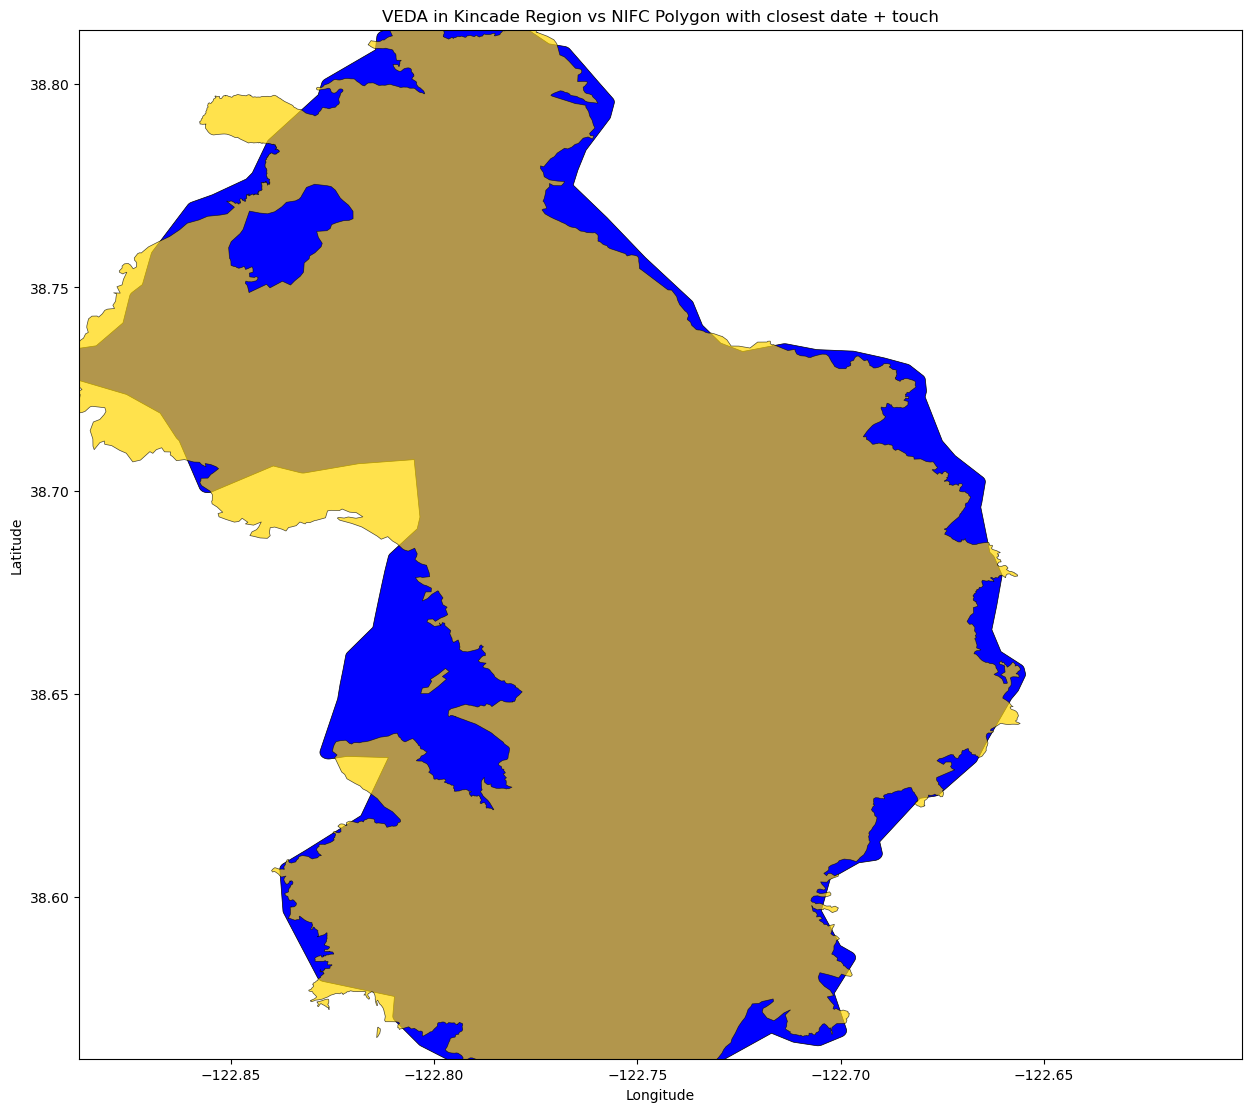

In [7]:
# for debugging purposes this is here

import matplotlib.pyplot as plt

print('SAMPLE PLOTTING VEDA V. REFERENCE')
print('\n')
print('BLUE: VEDA Kincade Fire Estimate')
print('GOLD: NIFC Reference Match')
print('\n')
print(f"VEDA date: {veda_kincade.t.values[0]}")
print(f"NIFC Reference date: {nifc_match['DATE_CUR_STAMP'].values[0]}")
print('\n')

fig, ax = plt.subplots(figsize=(15, 15))

# bound box as defined by us
ax.set_xlim(-122.887312, -122.601345)
ax.set_ylim(38.560242, 38.813395)

# veda_kincade.t.values[0]

# plot search results/what calculation is pulling from
v = veda_kincade.plot(ax=ax, legend=True, label="VEDA Kincade Fire Estimate", color="blue",edgecolor="black", linewidth=0.5 )
n = nifc_match.plot(ax=ax, legend=True, label="NIFC Nearest Date + Intersection", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("VEDA in Kincade Region vs NIFC Polygon with closest date + touch")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()
